In [432]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [433]:
# load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Pclass = Passenger class

SibSp = Number of Siblings/Spouses Aboard

Parch Number of Parents/Children Aboard

Fare = in British Pound 

Embarked = Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

Source: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

## Data Preparation

In [434]:
# Check missing value in train_data
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [435]:
# Check missing value in train_data
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [436]:
# Percentage of null in Age = 0.248 = 25%
train_data["Age"].isnull().sum()/train_data["Age"].count()

0.24789915966386555

In [437]:
# Checking unique values of Age
train_data["Age"].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [438]:
# check value with 0.???. 7 entries are less than 1
count = 0

for x in train_data.index:
    if train_data.loc[x, "Age"] < 1:
        count += 1
count

7

#### Flooring "Age" for both Train and Test

In [439]:
# Flooring all numbers
train_data["Age"] = train_data["Age"].apply(np.floor)
test_data["Age"] = test_data["Age"].apply(np.floor)

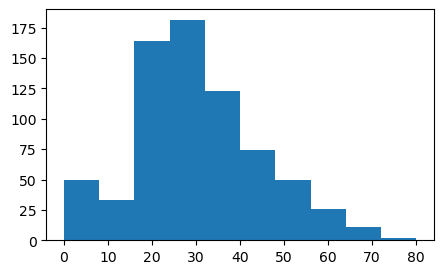

In [440]:
# Checking histogram of age (skewed)
plt.figure(figsize = (5, 3))
plt.hist(train_data["Age"])
plt.show()

#### Replacing "Age" nan with median for both Train and Test

In [441]:
# replace nan with median
train_data["Age"].fillna(train_data["Age"].median(skipna= True), inplace = True)
test_data["Age"].fillna(test_data["Age"].median(skipna= True), inplace = True)

In [442]:
# check P class
train_data["Pclass"].unique()

array([3, 1, 2])

In [443]:
# Check sex column
train_data["Sex"].unique()

array(['male', 'female'], dtype=object)

#### Map male: 0, female: 1 for both Train and Test

In [444]:
# Map male: 0, female: 1
train_data["Sex"] = train_data["Sex"].map({"male": 0, "female": 1})
test_data["Sex"] = test_data["Sex"].map({"male": 0, "female": 1})
train_data["Sex"].head()

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

In [445]:
# Check Embarked
train_data["Embarked"].isnull().sum() # 2 values missing

train_data["Embarked"].value_counts() # S = 644 , C = 168, Q = 77
train_data["Embarked"].value_counts(["S"]) # S = 72% , C = 19%, Q = 9%


S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

#### Filling na with "S" for both Train and Test

In [446]:
# Filling na with "S"
train_data["Embarked"] = train_data["Embarked"].fillna("S")
test_data["Embarked"] = test_data["Embarked"].fillna("S")

In [447]:
# One Hot Encoding for Embarked
encoder = OneHotEncoder()

# Making encoder_df
encoder_df = pd.DataFrame(encoder.fit_transform(train_data[["Embarked"]]).toarray())
encoder_df.columns = ["C", "Q", "S"]


#### Join the encoder_df and drop "Embarked" for both Train and Test 

In [448]:
# Join the encoder_df
train_data = train_data.join(encoder_df)
test_data = test_data.join(encoder_df)


# Drop Embarked column
train_data.drop("Embarked", axis = 1, inplace = True)
test_data.drop("Embarked", axis = 1, inplace = True)

In [449]:
# filling 'Fare" nan value with median for test_data
test_data["Fare"].fillna(test_data["Fare"].median(skipna = True), inplace = True)

In [450]:
# move around columns
train_new_columns = ["PassengerId", "Name", "Ticket", "Cabin", "Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "C", "Q", "S"]
train_data = train_data[train_new_columns]

test_new_columns = ["PassengerId", "Name", "Ticket", "Cabin", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "C", "Q", "S"]
test_data = test_data[test_new_columns]

## Logistic Regression Analysis

In [451]:
# spliting train/test data

X = train_data.iloc[:, 5:]
y = train_data.iloc[:, 4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [452]:
scaler_X = StandardScaler() 
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [453]:
logisticRegression_model = LogisticRegression(random_state = 10)

In [454]:
logisticRegression_model.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [455]:
prediction = logisticRegression_model.predict(X_test)
prediction

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0])

In [456]:
cm = confusion_matrix(y_test, prediction)
cm

array([[93, 17],
       [18, 51]])

In [457]:
print("Accuracy: ", (cm[0][0] + cm[1][1])/ len(y_test))

Accuracy:  0.8044692737430168


## Logistic Regression Visualisation

<AxesSubplot: xlabel='Sex', ylabel='Survived'>

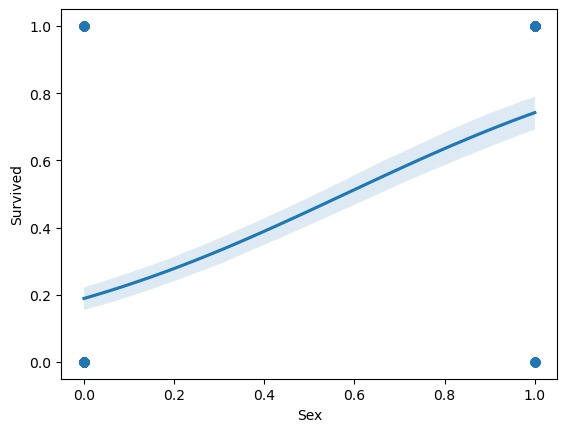

In [458]:
# Sex vs Survived
sns.regplot(x = X["Sex"], y = y, logistic = True)

<AxesSubplot: xlabel='Age', ylabel='Survived'>

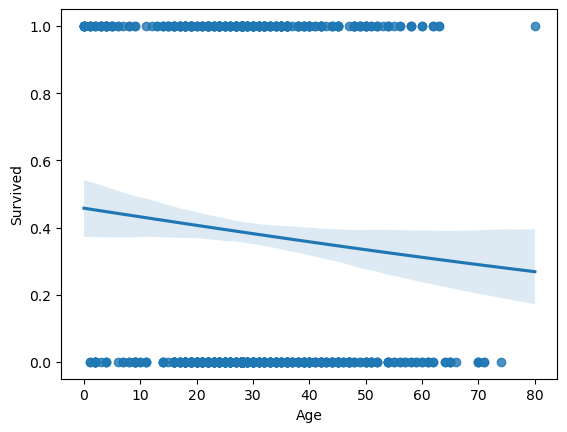

In [459]:
# Age vs Survived
sns.regplot(x = X["Age"], y = y, logistic = True)

<AxesSubplot: xlabel='Fare', ylabel='Survived'>

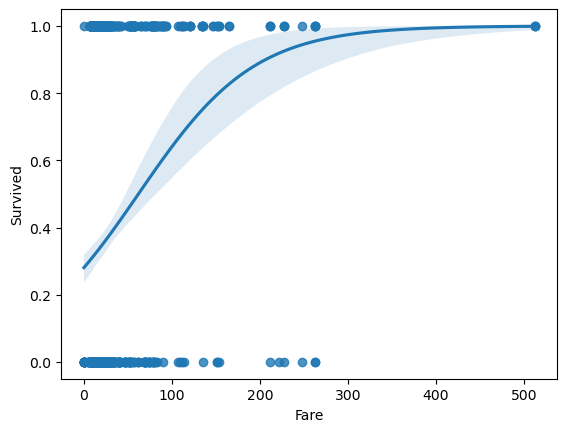

In [460]:
# Fare vs Survived
sns.regplot(x = X["Fare"], y = y, logistic = True)